In [2]:
# imports, global settings

import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.linear_model

import IPython as IP

import matplotlib.pyplot as plt
%matplotlib inline

import pylab
# print (pylab.rcParams.keys())
pylab.rcParams['figure.figsize'] = (18.0, 8.0)
pylab.rcParams['figure.facecolor'] = "white"
pylab.rcParams['axes.facecolor'] = "white"
pylab.rcParams['font.family'] = "sans"

import matplotlib
matplotlib.style.use('ggplot') # temporary for incompatibility of pandas with matplotlib
# pd.options.display.mpl_style = 'default'

pd.set_option('display.max_rows', 100)

In [3]:
% load_ext autoreload
% autoreload 2

In [4]:
# % install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
# % load_ext autotime

In [5]:
from read_utils import train_test, user_item_matrix
# from recommender import MostPopularRecommender
from pandas.tseries.offsets import *
import seaborn as sns
from eval_metrics import top_n
from recommender import ClusteringRecommender, SVDRecommender, MostPopularRecommender
import pandas as pd
import numpy
import math

Функция rolling_crossval(df, Recommender, k, step, fold_size, start_offset, time_func, time_func_params)  возвращает список точностей и дат конца тестового сета

df - датафрейм с данными

Recommender - класс рекомендатора

k - параметр рекомендатора (число кластеров)

step - шаг, с которым сдвигается старт теста

fold_size - размер тест сета

start_offset - дата старта первого теста получается вычитанием этого оффсета из текущей

time_func - callable следующей сигнатуры - time_func(order_date, time_func_params). Возвращает значение, прибавляемое в user_item матрицу

time_func_params - параметр функции взвешивания, если много коэффициентов - стоит положить дикт

In [6]:
from ts_crossval import rolling_crossval

Пример использования кроссвалидации и функции взвешивания

Взвешивание экспоненциальное приведено в качестве примера, дефолтное поведение кроссвалидатора - работать без взвешивания

In [34]:
df = pd.read_csv("../input/orders_items_registrations.csv", encoding="utf-8", low_memory=False)
df['order_date'] = pd.to_datetime(df['order_date'])
cur_time = df["order_date"].max()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39752 entries, 0 to 39751
Data columns (total 41 columns):
order_id                      39752 non-null int64
user_id                       39752 non-null int64
order_date                    39752 non-null datetime64[ns]
order_fulfilment_date         38140 non-null object
order_status                  39752 non-null int64
order_amount                  39752 non-null int64
order_metro                   35495 non-null object
order_address                 36632 non-null object
order_paid_by_bonuses         39752 non-null int64
order_is_first                39752 non-null int64
order_week                    39752 non-null int64
order_month                   39752 non-null int64
order_quarter                 39752 non-null int64
order_year                    39752 non-null int64
order_delivered_date          224 non-null object
order_delivered_time          215 non-null object
order_courier                 537 non-null float64
order_gift_amo

In [ ]:
def time_func(order_time, param):
    tdelta = cur_time - order_time
    tdelta = tdelta.days
    return math.exp(param*tdelta)

In [35]:
# svd_accs = rolling_crossval(df, SVDRecommender, k=6, step=DateOffset(months=0, days=14), 
#                             start_offset=DateOffset(months=6), time_func=time_func, time_func_params=0.5)
# most_pop_accs = rolling_crossval(df, MostPopularRecommender, k=6, step=DateOffset(months=0, days=14), 
#                                  start_offset=DateOffset(months=6), time_func=time_func, time_func_params=0.5)
# clustering_accs = rolling_crossval(df, ClusteringRecommender, k=6, step=DateOffset(months=0, days=14), 
#                                    start_offset=DateOffset(months=6), time_func=time_func, time_func_params=0.5)

svd_accs = rolling_crossval(df, SVDRecommender, k=6, step=DateOffset(months=1, days=0), 
                            start_offset=DateOffset(months=13), time_func_params=0.5)
most_pop_accs = rolling_crossval(df, MostPopularRecommender, k=6, step=DateOffset(months=1, days=0), 
                                 start_offset=DateOffset(months=13), time_func_params=0.5)
clustering_accs = rolling_crossval(df, ClusteringRecommender, k=6, step=DateOffset(months=1, days=0), 
                                   start_offset=DateOffset(months=13), time_func_params=0.5)

TypeError: train_test() got an unexpected keyword argument 'df'

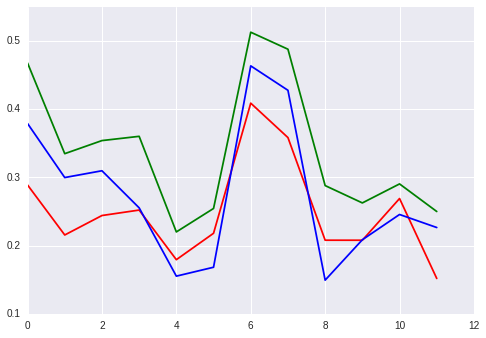

In [33]:
sns.plt.plot([i for i, val in enumerate(most_pop_accs)], [i[1] for i in most_pop_accs], "r")
sns.plt.plot([i for i, val in enumerate(svd_accs)], [i[1] for i in svd_accs], 'g')
sns.plt.plot([i for i, val in enumerate(clustering_accs)], [i[1] for i in clustering_accs], 'b')

sns.plt.show()

In [26]:
most_pop_accs

[(Timestamp('2015-07-04 17:39:24'), 0.28888888888888886),
 (Timestamp('2015-08-04 20:31:33'), 0.2155688622754491),
 (Timestamp('2015-09-04 20:34:33'), 0.2440944881889764),
 (Timestamp('2015-10-04 20:43:21'), 0.25210084033613445),
 (Timestamp('2015-11-04 20:03:55'), 0.1793478260869565),
 (Timestamp('2015-12-03 23:15:15'), 0.21806853582554517),
 (Timestamp('2016-01-03 23:34:36'), 0.4088397790055249),
 (Timestamp('2016-02-04 18:50:18'), 0.3583815028901734),
 (Timestamp('2016-03-04 19:07:12'), 0.2079207920792079),
 (Timestamp('2016-04-04 20:09:02'), 0.20786516853932585),
 (Timestamp('2016-05-04 20:30:11'), 0.26900584795321636),
 (Timestamp('2016-06-04 18:47:22'), 0.1518324607329843)]

In [22]:
all_res = np.asarray([np.asarray(most_pop_accs)[:, 1], np.asarray(svd_accs)[:, 1], np.asarray(clustering_accs)[:, 1]]).T
all_res

array([[0.28888888888888886, 0.3951612903225806, 0.3790322580645161],
       [0.2155688622754491, 0.26914660831509846, 0.29978118161925604],
       [0.2440944881889764, 0.3893805309734513, 0.30973451327433627],
       [0.25210084033613445, 0.260752688172043, 0.2553763440860215],
       [0.1793478260869565, 0.20235756385068762, 0.15520628683693516],
       [0.21806853582554517, 0.2448700410396717, 0.16826265389876882],
       [0.4088397790055249, 0.555793991416309, 0.463519313304721],
       [0.3583815028901734, 0.4718875502008032, 0.42771084337349397],
       [0.2079207920792079, 0.18666666666666668, 0.14933333333333335],
       [0.20786516853932585, 0.28677839851024206, 0.2085661080074488],
       [0.26900584795321636, 0.3645224171539961, 0.24561403508771928],
       [0.1518324607329843, 0.2181208053691275, 0.22651006711409397]], dtype=object)

In [25]:
print np.mean(all_res, axis=0)

[0.250159582733532 0.32045321266588983 0.2740539115000537]
